In [33]:
import tensorflow as tf
from tensorflow import keras 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from datetime import datetime 

In [34]:
# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [35]:
df = pd.read_csv("commodity_historical.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   780 non-null    object 
 1   Crude Oil Brent Price  780 non-null    float64
 2   Cocoa Price            780 non-null    float64
 3   Gold Price             780 non-null    float64
dtypes: float64(3), object(1)
memory usage: 24.5+ KB


In [36]:
data = df[["date", "Cocoa Price"]]
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         780 non-null    object 
 1   Cocoa Price  780 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.3+ KB


In [37]:
data['date'] = pd.to_datetime(data['date'])

/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_91355/736794659.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
data = data[data["date"] >= "1980-01-01"]  # instead of 1960 which is statistically insignificant

In [39]:
import plotly.express as px
import plotly.graph_objects as go


def plotting(title, data, x, y, x_label, y_label, text=False, lam=None):
    """General function to plot the data."""
    fig = px.line(data, x=data[x], y=data[y], labels={x: x_label, y: y_label})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title, width=650, title_x=0.5, height=400)
    if text:
      fig.add_annotation(
          x='1952-12-20', y=10, text=f'Lambda = {lam:.3f}',
          align='left', yanchor='bottom', showarrow=False,
          font=dict(size=20, color="black", family="Courier New, monospace"),
          bordercolor='black', borderwidth=2, bgcolor="white"
      )
    fig.show()


def add_separator(width=650):
    """Add a horizontal line as a separator."""
    fig = go.Figure()
    fig.add_hline(y=0.5, line_dash="dot", line_color="gray", line_width=2)
    fig.update_layout(height=50, width=width, margin=dict(l=20, r=20, t=20, b=20), xaxis_visible=False, yaxis_visible=False)
    fig.show()


In [40]:
plotting(title='Cocoa Over Time', data=data, x='date', y='Cocoa Price', x_label='Date', y_label='Price ()')
# add_separator()

In [41]:
len(data)

540

## Data Split

In [42]:
train = data.iloc[:528]  # 1980 to 2023
test = data.iloc[528:]  # 2024

In [43]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data["Crude Oil Brent Price"])
scaler.fit(train[["Cocoa Price"]])
scaled_train = scaler.transform(train[["Cocoa Price"]])
scaled_test = scaler.transform(test[["Cocoa Price"]])

In [44]:
train_size = int(len(scaled_train) * 0.95)  # 95% train, 5% validation
train_data, val_data = scaled_train[:train_size], scaled_train[train_size:]

In [45]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Define Parameters
lookback = 10  # Number of past steps to use as input
batch_size = 32  # Number of samples per batch
n_features = 1

# Initialize Generator
from tensorflow.keras.utils import timeseries_dataset_from_array
train_generator = timeseries_dataset_from_array(
    data=scaled_train,
    targets=scaled_train,
    sequence_length=lookback,
    batch_size=batch_size,
)
# train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=lookback, batch_size=batch_size)
# train_generator = TimeseriesGenerator(train_data, train_data, length=lookback, batch_size=batch_size)
# val_generator = TimeseriesGenerator(val_data, val_data, length=lookback, batch_size=batch_size)

## Build base lstm

In [46]:
# Set random seed for reproducibility
tf.random.set_seed(3)

# Build LSTM model
model = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True, input_shape=(lookback, n_features)),  # 1st layer with 170 units as specified
    keras.layers.LSTM(256, return_sequences=False),  # 2nd layer
    # keras.layers.Dense(128, activation="relu"),  # 3rd Layer (Dense)
    # keras.layers.Dropout(0.1),  # 4th Layer (Dropout)
    keras.layers.Dense(1)  # Final Output Layer
])

# Configure ADAM optimizer with specified parameters
# optimizer = keras.optimizers.Adam(
#     learning_rate=0.001,  # Specified learning rate
#     beta_1=0.9,  # First moment estimate decay rate
#     beta_2=0.999  # Second moment estimate decay rate
# )

model.compile(
    optimizer="adam", 
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsolutePercentageError()]
)


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [47]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,761 (3.01 MB)

 Trainable params: 789,761 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# fit model
model.fit(train_generator, epochs=50)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0606 - mean_absolute_percentage_error: 111518.9219
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0124 - mean_absolute_percentage_error: 18264.8809
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0093 - mean_absolute_percentage_error: 132877.9844
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0041 - mean_absolute_percentage_error: 46142.2500
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0046 - mean_absolute_percentage_error: 16455.9414
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0043 - mean_absolute_percentage_error: 48992.8945
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0047 - mean_absolute_percentage_error: 57009.5547
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0047 - mean_absolute_percentage_error: 43306.0000
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038 - mean_absolute_percentage_error: 21536.5430

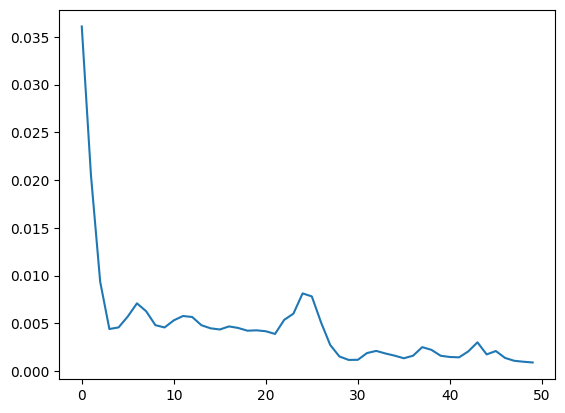

In [49]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [50]:
def plot_forecasts(df: pd.DataFrame, forecasts: np.ndarray, col: str, title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    
    # Plot true values
    fig.add_trace(go.Scatter(x=df['date'], y=df[col], name='Truth', mode='lines'))
    
    # Plot predicted values
    fig.add_trace(go.Scatter(x=df['date'], y=forecasts.flatten(), name='Prediction', mode='lines'))
    
    fig.update_layout(
        template="simple_white", font=dict(size=18), title_text=title,
        width=650, title_x=0.5, height=400, xaxis_title='Date', yaxis_title='Price'
    )
    
    fig.show()

## Test set

In [51]:
test_predictions = []

first_eval_batch = scaled_train[-lookback:]
current_batch = first_eval_batch.reshape((1, lookback, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


# input_sequence = np.vstack([scaled_train[-lookback:], scaled_test])

# # Initialize predictions array
# test_predictions = []

# # For each point in the test set
# for i in range(len(scaled_test)):
#     # Extract the current window (LOOKBACK previous points)
#     current_window = input_sequence[i:i+lookback].reshape(1, lookback, n_features)
    
#     # Generate prediction for the next point
#     pred = model.predict(current_window)[0]
#     test_predictions.append(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [52]:
# Ensure test predictions is a 2D NumPy array before inverse scaling
true_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))

# Extract correct test set dates
test_dates = data['date'].iloc[len(train):]

In [53]:
plot_forecasts(
    pd.DataFrame({
        'date': test_dates, 
        "Cocoa Price": test["Cocoa Price"].values
    }), 
    true_predictions, 
    "Cocoa Price", 
    "LSTM forecast for Cocoa test set"
)

In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Cocoa Price'], true_predictions))
rmse

4.260377488401741

In [55]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(test['Cocoa Price'], true_predictions)
print(f'mape: {mape*100:.2f}%')

mape: 52.76%


In [ ]:
model.save("saved_models/cocoa_lstm_model.keras")

## Grid Search Hyperparameter Tuning

In [ ]:
import keras_tuner as kt

# Set random seed for reproducibility
tf.random.set_seed(3)

# Assume `train_data` and `val_data` are numpy arrays (shape: [samples, features])
n_features = train_data.shape[1]

# Tune batch sizes
batch_sizes = [16, 32, 64]

# Create dictionary to store generators for different batch sizes
generators = {}

for batch_size in batch_sizes:
    generators[batch_size] = {
        'train': timeseries_dataset_from_array(
            data=train_data,
            targets=train_data[:, -1],
            sequence_length=lookback,
            batch_size=batch_size
        ),
        'val': timeseries_dataset_from_array(
            data=val_data,
            targets=val_data[:, -1],
            sequence_length=lookback,
            batch_size=batch_size
        )
    }

def build_model(hp: kt.HyperParameters):
    """
    Model builder function for Keras Tuner
    """

    model = keras.models.Sequential()

    # Tune the number of units in the first LSTM layer
    units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    model.add(keras.layers.LSTM(
        units=units_1,
        return_sequences=True,
        input_shape=(lookback, n_features)
    ))

    # Tune the number of units in the second LSTM layer
    units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    model.add(keras.layers.LSTM(
        units=units_2,
        return_sequences=False
    ))

    # Tune the number of units in the dense layer
    # units_dense = hp.Int('units_dense', min_value=64, max_value=256, step=64)
    # model.add(keras.layers.Dense(units=units_dense, activation='relu'))

    # Tune the dropout rate
    # dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    # model.add(keras.layers.Dropout(rate=dropout_rate))

    # Output layer
    model.add(keras.layers.Dense(1))

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 3e-4, 1e-3, 3e-3])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.MeanSquaredError(), 
        metrics=[keras.metrics.MeanAbsoluteError()]
    )

    return model

# Initialize the tuner
tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=50,  # Number of different hyperparameter combinations to try
    directory='tuning_dir',
    project_name='cocoa_lstm_tuning'
)

# Print search space summary
tuner.search_space_summary()

# Tune epochs
epoch_choices = [50, 100, 150]

# Define early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Start the hyperparameter search
for batch_size in batch_sizes:
    tuner.search(
        generators[batch_size]['train'],
        epochs=max(epoch_choices),
        validation_data=generators[batch_size]['val'],
        callbacks=[early_stopping]
    )

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters found:
- First LSTM layer units: {best_hps.get('units_1')}
- Second LSTM layer units: {best_hps.get('units_2')}
- Dense layer units: {best_hps.get('units_dense')}
- Dropout rate: {best_hps.get('dropout_rate')}
- Learning rate: {best_hps.get('learning_rate')}
""")

# Tune Batch Size & Epochs
best_batch_size = None
best_epoch = None
best_val_loss = float('inf')

for batch_size in batch_sizes:
    for epochs in epoch_choices:
        print(f"Testing batch size {batch_size} with {epochs} epochs...")

        # Build the best model found
        model = tuner.hypermodel.build(best_hps)

        # Train with current batch size & epochs
        history = model.fit(
            generators[batch_size]['train'],
            epochs=epochs,
            validation_data=generators[batch_size]['val'],
            callbacks=[early_stopping],
            verbose=0  # Suppress output for cleaner logs
        )

        # Get the final validation loss
        final_val_loss = min(history.history['val_loss'])

        # Update best batch size & epoch count if a lower val_loss is found
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_batch_size = batch_size
            best_epoch = epochs

print(f"""
Best batch size and epoch found:
- Batch size: {best_batch_size}
- Epochs: {best_epoch}
- Final validation loss: {best_val_loss}
""")

# Train the Best Model with Best Batch Size & Epochs
best_model: kt.HyperModel = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    generators[best_batch_size]['train'],
    epochs=best_epoch,
    validation_data=generators[best_batch_size]['val'],
    callbacks=[early_stopping]
)

# Save the best model
best_model.save('saved_models/best_cocoa_lstm_model.keras')


Trial 50 Complete [00h 00m 10s]
val_loss: 0.0004477384500205517

Best val_loss So Far: 0.00011343510414008051
Total elapsed time: 00h 07m 17s


KeyError: 'lookback does not exist.'

In [71]:
test_predictions = []

first_eval_batch = scaled_train[-lookback:]
current_batch = first_eval_batch.reshape((1, lookback, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = best_model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


# Ensure test predictions is a 2D NumPy array before inverse scaling
true_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
# Extract correct test set dates
test_dates = data['date'].iloc[len(train):]


plot_forecasts(
    pd.DataFrame({
        'date': test_dates, 
        "Cocoa Price": test["Cocoa Price"].values
    }), 
    true_predictions, 
    "Cocoa Price", 
    "LSTM Best forecast for Cocoa test set"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [72]:
best_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 10, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,117 (148.90 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,412 (99.27 KB)

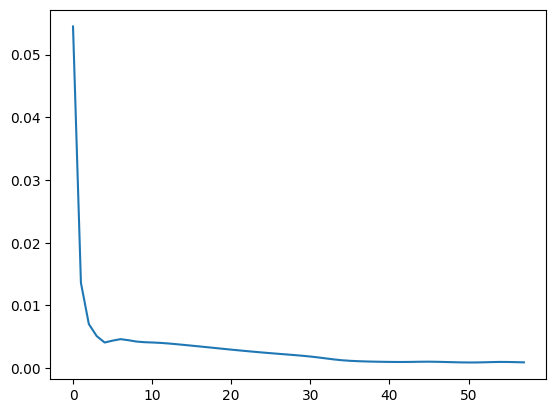

In [73]:
loss_per_epoch = best_model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [74]:
rmse=sqrt(mean_squared_error(test['Cocoa Price'], true_predictions))
rmse

4.447908325200282

In [75]:
mape = mean_absolute_percentage_error(test['Cocoa Price'], true_predictions)
print(f'mape: {mape*100:.2f}%')

mape: 55.23%
